Demonstration of framework use for semantic entrope probes implementation

### Setup

In [1]:
# Imports
from pathlib import Path
import sys

import random

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

from sklearn.linear_model import LogisticRegression

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.9.1+cu128
cuda available: True
gpu: NVIDIA GeForce RTX 3060


In [2]:
# Imports framework functions

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.dataset.implementations import TriviaQADataset
from src.dataset import SubstringMatchEvaluator
from src.scoring.sampling import SemanticEntropyScorer
from src.dataset.enrichers import GreedyGenerationEnricher, ActivationEnricher, SemanticEntropyEnricher
from src.model import MistralModel
from src.training import ProbeManager, find_best_probe, save_probe, plot_auc_by_layer

In [3]:
# Params
SEED = 42
random.seed(SEED)
CREATE_DATASETS = True  # if False skips first 7 steps and just trains probes

# Dataset
n_samples = 100
n_train = 60
n_val = 20
n_test = 20
assert n_samples == n_train + n_val + n_test

shuffle_buffer = 10_000
split_name = "validation"

# Model
MODEL = "../models/mistral-7b-instruct" # "mistralai/Mistral-7B-Instruct-v0.1" # choose model name instead of path to local folder with model
ENTAILMENT_MODEL = '../models/roberta-large-mnli'

# Step 4 parameters
# ----- generation -----
max_new_tokens_greedy = 64
greedy_do_sample = False  # greedy
use_chat_template = True
SYSTEM_PROMPT = "Answer as briefly as possible. Prefer one or a few words. Do not add explanations."  # Probably makes quality worse

VERBOSE_EVERY = 100

# ----- activations / SEP -----
layers_to_capture = [0, 4, 8, 12, 16, 20, 24, 28, 31]
# positions corresponding to generated part
# 0 = TBG (first generated token)
# -2 = SLT (second-to-last generated token).
positions_generated = [0, -2]

# Step 5 semantic entropy calculation
SE_SAMPLING_N = 10
max_new_tokens_sampling = 64

# Save datasets path
SAVE_DIR = Path("../data/sep_demo")

# Probe training params
PROBE_MAX_ITER = 500
PROBE_C = 1.0
PROBE_SOLVER = "lbfgs"
USE_SAMPLE_WEIGHTS = False
K_FOLDS = 5

# Where to save probes
OUTPUT_LINEAR_PROBES = "../models/probes/sep_demo"

### 1. Loading data Trivia QA

In [4]:
data = TriviaQADataset.from_huggingface(
    split="validation",
    n_samples=n_samples,
    seed=SEED,
    shuffle_buffer=shuffle_buffer
)

train_data, val_data, test_data = data.split(n_train, n_val, n_test, seed=SEED)
print(train_data[0].keys())

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

dict_keys(['prompt', 'gt_answers'])


### 2. Load models

In [5]:
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    device_map="auto",
    quantization_config=quant_config,
)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id

wrapper = MistralModel(model, tokenizer, system_prompt="Answer briefly.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Greedy answers generations

In [6]:
evaluator = SubstringMatchEvaluator()
greedy_gen_enricher = GreedyGenerationEnricher(wrapper, evaluator, max_new_tokens=max_new_tokens_greedy)

In [7]:
train_data, val_data, test_data = greedy_gen_enricher(train_data), greedy_gen_enricher(val_data), greedy_gen_enricher(test_data)

In [8]:
train_data[0].keys()

dict_keys(['prompt', 'gt_answers', 'greedy_answer', 'is_correct'])

### 4. Activations aquistision

In [9]:
activation_enricher = ActivationEnricher(wrapper, layers_to_capture, positions_generated)

In [10]:
train_data, val_data, test_data = activation_enricher(train_data), activation_enricher(val_data), activation_enricher(test_data)

In [11]:
train_data[0].keys()

dict_keys(['prompt', 'gt_answers', 'greedy_answer', 'is_correct', 'activations'])

### 5. Semantic entropy calculation

In [12]:
se_scorer = SemanticEntropyScorer(n_samples=SE_SAMPLING_N)
se_enricher = SemanticEntropyEnricher(se_scorer, add_weights=True)

Some weights of the model checkpoint at ../models/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
train_data = se_enricher.enrich_dataset(train_data, wrapper)

In [14]:
se_gamma = train_data[0]['se_gamma']
se_enricher.fit_gamma = False
se_enricher.gamma = se_gamma

In [15]:
val_data, test_data = se_enricher.enrich_dataset(val_data, wrapper), se_enricher.enrich_dataset(test_data, wrapper)

In [16]:
print(val_data[0]['se_gamma'])
print(val_data[0]['se_gamma'] == train_data[0]['se_gamma'])

0.7788810001458762
True


Continue make dataset. Current step is apply semantic entropy calculation. Here I will use functions from semantc_unsertainty/uncertainty module from github.com/jlko/semantic_uncertainty repository.

Finally we have got semantic entropy probes dataset. Here one sample description.

In [17]:
sample = val_data[0]
print(f'One sample keys: {sample.keys()}\n')

print(f'Prompt: {sample['prompt']}, GT answers (first 3): {sample['gt_answers'][:3]}')
print(f'Answer: {sample['greedy_answer']}, Correctness: {sample['is_correct']}\n')

print(f'Captured activations keys: {sample['activations'].keys()}')
print(f'Activations positions: {sample['activations']['positions']} and layes: {sample['activations']['layers']}')
print(f'Activation hidden dim: {len(sample['activations']['acts'][0][31])} and first values: {sample['activations']['acts'][0][31][:5]}\n')

print(f'Sampled answers: {sample['sampling_answers']}, Cluster ids: {sample['semantic_ids']}')
print(f'Raw semantic entropy: {sample['se_raw']}, binary se labels: {sample['se_binary']}')
print(f'Semantic entropy gamma (th): {sample['se_gamma']}, se weigths: {sample['se_weight']}')

One sample keys: dict_keys(['prompt', 'gt_answers', 'greedy_answer', 'is_correct', 'activations', 'sampling_answers', 'se_raw', 'semantic_ids', 'se_gamma', 'se_binary', 'se_weight'])

Prompt: "What was the name of the Spencers' baby in the 1970's sitcom ""Some Mothers Do 'Ave 'Em""?", GT answers (first 3): ['jessica song', 'jessica disambiguation', 'jessica song disambiguation']
Answer: The name of the Spencers' baby in "Some Mothers Do 'Ave 'Em" was Jerry., Correctness: 0.0

Captured activations keys: dict_keys(['positions', 'layers', 'acts', 'gen_len'])
Activations positions: [0, -2] and layes: [0, 4, 8, 12, 16, 20, 24, 28, 31]
Activation hidden dim: 4096 and first values: tensor([-2.1484,  2.1992,  1.9092,  5.4023, -7.9375], dtype=torch.float16)

Sampled answers: ["The name of the Spencers' baby in the 1970's sitcom", "The name of the Spencers' baby in the 1970's sitcom", "The name of the Spencers' baby in the 1970's sitcom", 'The name of the Spencers\' baby in "Some Mothers Do \'Av

### 6. Linear probes learn

[1/20] target=se_binary, pos=0, layer=0: cv_auc=0.435±0.050, test_auc=0.495
[2/20] target=se_binary, pos=0, layer=8: cv_auc=0.632±0.188, test_auc=0.505
[3/20] target=se_binary, pos=0, layer=16: cv_auc=0.568±0.114, test_auc=0.616
[4/20] target=se_binary, pos=0, layer=24: cv_auc=0.594±0.135, test_auc=0.667
[5/20] target=se_binary, pos=0, layer=31: cv_auc=0.593±0.101, test_auc=0.616
[6/20] target=se_binary, pos=-2, layer=0: cv_auc=0.630±0.100, test_auc=0.626
[7/20] target=se_binary, pos=-2, layer=8: cv_auc=0.733±0.111, test_auc=0.576
[8/20] target=se_binary, pos=-2, layer=16: cv_auc=0.739±0.103, test_auc=0.586
[9/20] target=se_binary, pos=-2, layer=24: cv_auc=0.694±0.077, test_auc=0.556
[10/20] target=se_binary, pos=-2, layer=31: cv_auc=0.672±0.049, test_auc=0.465
[11/20] target=is_correct, pos=0, layer=0: cv_auc=0.483±0.117, test_auc=0.583
[12/20] target=is_correct, pos=0, layer=8: cv_auc=0.555±0.170, test_auc=0.635
[13/20] target=is_correct, pos=0, layer=16: cv_auc=0.630±0.100, test_auc

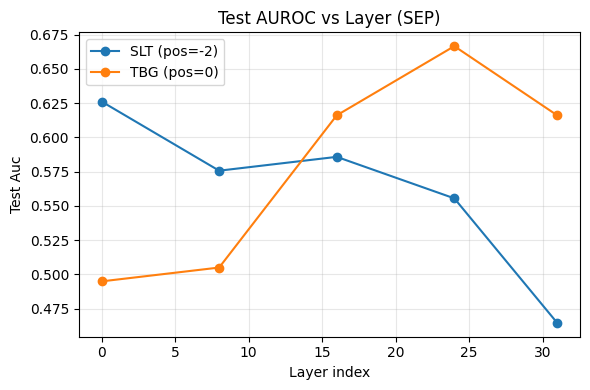

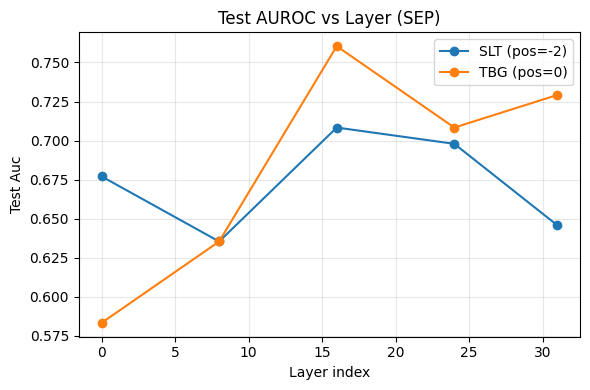

In [20]:
# 1. Create ProbeManager
manager = ProbeManager(
    probe_class=LogisticRegression,
    probe_params={'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'},
    seed=42
)

# 2. Train probes for all combinations
results = manager.train_every_combination(
    train_data, val_data, test_data,
    positions=[0, -2],  # TBG and SLT
    layers=[0, 8, 16, 24, 31],
    targets=['se_binary', 'is_correct'],
    k_folds=5,
    weight_field='se_weight',
    use_weights_for_targets=['se_binary'],
    eval=True,
    verbose=True
)


# 3. Visualize results
plot_auc_by_layer(
    results,
    target_field='se_binary',
    title='Test AUROC vs Layer (SEP)'
)

plot_auc_by_layer(
    results,
    target_field='is_correct',
    title='Test AUROC vs Layer (SEP)'
)